In [1]:
import shap
import torch
import numpy 
import transformers
from transformers import AutoTokenizer,AutoModelForSequenceClassification, Trainer,TextClassificationPipeline
import numpy as np
import pandas as pd

In [2]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, problem_type="multi_label_classification")
num_labels=5
model = AutoModelForSequenceClassification.from_pretrained('C:\RMM\Medical4\multilabelmodel', num_labels=num_labels).to('cuda')
pipe=TextClassificationPipeline(model=model,tokenizer=tokenizer,device=0)

In [3]:
cor_x = np.load("multilabeltest.npy",allow_pickle=True)
cor_reviews = [review[1] for review in cor_x]
cor_labels = [review[0] for review in cor_x]

In [5]:
def mask_top_k(k, pred_label_no_mask, values, returned_tokens):
    """
    masked the k tokens that have the max shap values
    :param k: specify the largest k value
    :param values: shap values
    :param returned_tokens: a list of tokens
    :return: review, which is a str constructed from a list words
    """
    shap_values_0, shap_values_1,shap_values_2,shap_values_3,shap_values_4 = zip(*values)
    if pred_label_no_mask == 0:
        values = shap_values_0
    elif  pred_label_no_mask == 1:
        values = shap_values_1
    elif  pred_label_no_mask == 2:
        values = shap_values_2  
    elif  pred_label_no_mask == 3:
        values = shap_values_3  
    elif  pred_label_no_mask == 4:
        values = shap_values_4
    # print(values)
    values = np.array(values)
    # ids_top_k = np.argpartition(values, -k)[-k:]
    ids_top_k = (-values).argsort()[:k]
    for idx in ids_top_k:
        # print(idx)
        returned_tokens[idx] = "[UNK] "
    masked_review = "".join(returned_tokens)
    # print(masked_review)
    return masked_review

def predict_label(pipe, masked_review):
    """
    predict the label for the masked_review
    :param pipe: pipeline
    :param masked_review: string
    :return: 0 or 1, indicating the label
    """
    prediction = pipe([masked_review])
    labelstr=prediction[0]['label']
    if labelstr == 'LABEL_0':
        pred_label=0
    elif labelstr == 'LABEL_1':
        pred_label=1
    elif labelstr == 'LABEL_2':
        pred_label=2
    elif labelstr== 'LABEL_3':
        pred_label=3
    elif labelstr == 'LABEL_4':
        pred_label=4
    return pred_label

In [69]:
shap_values_list = []
token_data_list = []
top_k = [1, 5, 9, 13,17,21,25,29,33,37,41]
all_labels =[]
# use GPU
gpu_explainer = shap.Explainer(pipe, tokenizer)
i = 0
for review, label in zip(cor_reviews, cor_labels):
    label=label-1
    print(f"process {i}-th review")
    i += 1
    label4review =[]
    label4review.append(label)
    # to-do: truncate review if len(review)>80
    tokens = tokenizer.tokenize(review)
    if len(tokens) > 80:
        tokens_truncated = tokens[:80]
        review = " ".join(token for token in tokens_truncated)
    pred_label_no_mask = predict_label(pipe, review) # predicted label for review without mask
    label4review.append(pred_label_no_mask)
    shap_values = gpu_explainer([review])
    values = shap_values.values[0] # 2-dim ndarray
    returned_tokens = shap_values.data[0]
    for k in top_k:
        masked_review = mask_top_k(k, pred_label_no_mask, values, returned_tokens) # mask review by the shap values
        predicted_label= predict_label(pipe, masked_review)
        label4review.append(predicted_label)
    # label4review = [True_label, pred_label_without_mask, masked_label_1, masked_label_2, masked_review_3, masked_review_4]
    all_labels.append(label4review)

process 0-th review


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


process 1-th review
process 2-th review
process 3-th review
process 4-th review
process 5-th review
process 6-th review
process 7-th review
process 8-th review
process 9-th review
process 10-th review
process 11-th review
process 12-th review
process 13-th review
process 14-th review
process 15-th review
process 16-th review
process 17-th review
process 18-th review
process 19-th review
process 20-th review
process 21-th review
process 22-th review
process 23-th review
process 24-th review
process 25-th review
process 26-th review
process 27-th review
process 28-th review
process 29-th review
process 30-th review
process 31-th review
process 32-th review
process 33-th review
process 34-th review
process 35-th review
process 36-th review
process 37-th review
process 38-th review
process 39-th review
process 40-th review
process 41-th review
process 42-th review
process 43-th review
process 44-th review
process 45-th review
process 46-th review
process 47-th review
process 48-th review
p

In [70]:
df = pd.DataFrame(np.array(all_labels))

In [71]:
filtered_df = df.loc[df[0]==df[1]]

In [72]:
from sklearn.metrics import accuracy_score

In [78]:
accuracy_masked=[accuracy_score(filtered_df[1], filtered_df[1]),accuracy_score(filtered_df[1], filtered_df[2]), accuracy_score(filtered_df[1], filtered_df[3]), accuracy_score(filtered_df[1], filtered_df[4]), accuracy_score(filtered_df[1], filtered_df[5]),accuracy_score(filtered_df[1], filtered_df[6]),accuracy_score(filtered_df[1], filtered_df[7]),accuracy_score(filtered_df[1], filtered_df[8]),accuracy_score(filtered_df[1], filtered_df[9]),accuracy_score(filtered_df[1], filtered_df[10]),accuracy_score(filtered_df[1], filtered_df[11]),accuracy_score(filtered_df[1], filtered_df[12])]

In [79]:
print(accuracy_masked)

[1.0, 0.7857142857142857, 0.5642857142857143, 0.5071428571428571, 0.4928571428571429, 0.4857142857142857, 0.4714285714285714, 0.45, 0.45, 0.45, 0.45714285714285713, 0.4642857142857143]


Report the final accuracy tendency

Plot both binary model and multilabel model in one plot.

In [80]:
binary_acc=[1,0.7777777777777778, 0.46405228758169936, 0.3464052287581699, 0.3333333333333333, 0.3790849673202614, 0.3660130718954248, 0.39869281045751637, 0.42483660130718953, 0.4179084967320261, 0.437516339869281, 0.42058823529411765]
multi_acc=accuracy_masked

In [77]:
import matplotlib.pyplot as plt

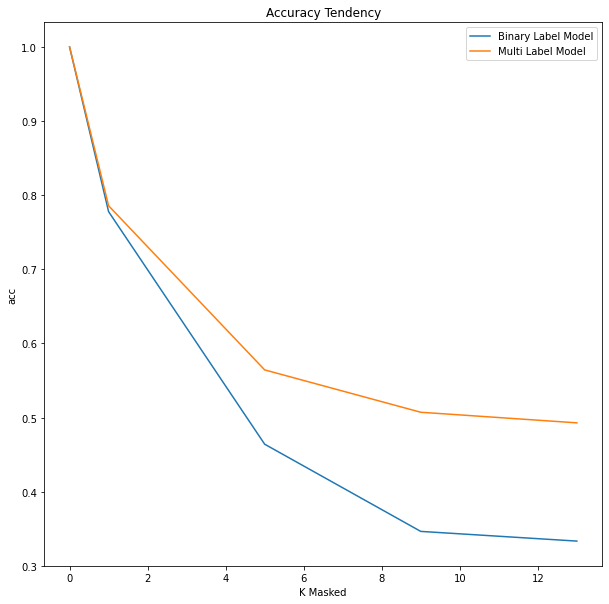

In [89]:
x=[0,1,5,9,13]
plt.plot(x,binary_acc[:5],label='Binary Label Model')
plt.plot(x,multi_acc[:5],label='Multi Label Model')
plt.xlabel('K Masked')
plt.ylabel('acc')
plt.title('Accuracy Tendency')
plt.legend(loc="upper right")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

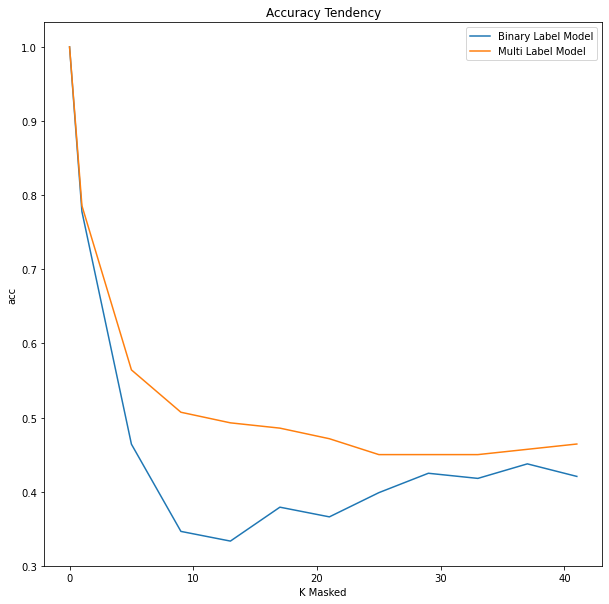

In [90]:
x=[0,1, 5, 9, 13,17,21,25,29,33,37,41]
plt.plot(x,binary_acc,label='Binary Label Model')
plt.plot(x,multi_acc,label='Multi Label Model')
plt.xlabel('K Masked')
plt.ylabel('acc')
plt.title('Accuracy Tendency')
plt.legend(loc="upper right")
plt.show()